In [1]:
import math
import torch
import gpytorch
print(gpytorch.__version__)
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

1.11


In [3]:
print(torch.__version__)

2.2.2


In [5]:
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [6]:
def remove_col_outlier(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    keep_inds = ~((df[col] < (Q1 - 2 * IQR)) |(df[col] > (Q3 + 2 * IQR)))
    df = df[keep_inds]
    df.reset_index(inplace = True,drop= True)
    return df,keep_inds

In [2]:
import re
data_path = '/Users/chenya68/Documents/GitHub/BFO/data/vis-open-x.csv'
df = pd.read_csv(data_path)
df.columns = [re.sub('[^A-Za-z0-9Δ%]+', '_', element) for element in df.columns]
df.columns  = [re.sub('%','_PCT',element) for element in df.columns]

df_subset = df.iloc[:5000,:]
col_names = df.columns
cols_group = col_names[-23:]
cols_feature = col_names.difference(cols_group)
df_x = df_subset[cols_feature]
        
data_path = '/Users/chenya68/Documents/GitHub/BFO/data/vis-open-y.csv'
df_y = pd.read_csv(data_path)
df_y.columns = [re.sub('[^A-Za-z0-9Δ%]+', '_', element) for element in df_y.columns]
df_y.columns  = [re.sub('%','_PCT',element) for element in df_y.columns]
df_y = df_y.iloc[:5000,:]
        
arr_task_ohe = df_subset[cols_group].to_numpy()
arr_task_label = np.where(arr_task_ohe==1)[1]
df_x['task_ind'] = arr_task_label
#df_y['task_ind'] = arr_task_label

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_53258/2758723646.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = arr_task_label


In [3]:
print(df.shape)

(43815, 182)


In [14]:
value_counts = df_x['task_ind'].value_counts().sort_index()

print(value_counts)
df_value_counts = pd.DataFrame(value_counts)
df_value_counts.to_csv('output/open-vis/df_value_counts.csv')


#value_counts_sorted = df_x['task_ind'].value_counts().sort_values(ascending=True)

#print(value_counts_sorted)

task_ind
0     277
1     131
2     173
3     221
4     113
5     231
6     260
7     335
8       4
9       9
10     15
11     59
12    118
13    414
14    357
15     42
16    160
17    320
18    609
19    420
20     85
21    208
22    439
Name: count, dtype: int64


In [8]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['none','label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'multi-task-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax'
cate_transform_option = 'none'
#remove_pred_outlier_option= 0

output_rank_option = 6 #if 0, no correlation between output
task_rank_option = 3#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'


model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        output_rank_label = 'output_rank_'+str(output_rank_option)
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''



folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,
                        output_rank_label,task_rank_label,lik_rank_label])

os.chdir('/Users/chenya68/Documents/GitHub/BFO')
figPath = 'output/visopen-0114/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/visopen-0114/multi-task-multi-output-x-minmax-y-minmax-cate_transform_none-task_rank_6-task_rank_3-lik_rank_1


In [ ]:

"""
df_y_1 = pd.DataFrame(df[cols_target[0]])
df_y_2 = pd.DataFrame(df[cols_target[1]])
df_y_3 = pd.DataFrame(df[cols_target[2]])
df_y_1.columns = ['y']
df_y_2.columns = ['y']
df_y_3.columns = ['y']

df_xy_1 = pd.concat((df_x,df_y_1),axis = 1)
df_xy_2 = pd.concat((df_x,df_y_2),axis = 1)
df_xy_3 = pd.concat((df_x,df_y_3),axis = 1)
df_xy_1['task_ind'] = 0
df_xy_2['task_ind'] = 1
df_xy_3['task_ind'] = 2
total_df_xy_long = pd.concat((df_xy_1,df_xy_2,df_xy_3),axis = 0)
total_df_xy_long.reset_index(inplace = True, drop = True)
#total_df_xy_long
total_df_y_long = total_df_xy_long[['y']]
total_df_x_long = total_df_xy_long[cols_feature00]
#total_df_y_long
"""

In [12]:
"""
df_y['task_ind'] = arr_task_label
        
splits_x = list(df_x.groupby(['task_ind'],dropna=True))
splits_y = list(df_y.groupby(['task_ind'],dropna=True))
ndata = [len(df[1]) for df in splits_x]
        
X_raw_list = []
Y_raw_list = []
for task_ind in range(23):
    X_raw_list.append(splits_x[task_ind][1].to_numpy())
    Y_raw_list.append(splits_y[task_ind][1].to_numpy())
        
n_output = 6
n_task = 23

X_output_with_replicates = []
for i in range(n_task):
    X_output_with_replicates.append(X_raw_list[i])
arr_X_with_replicates = np.vstack(X_output_with_replicates)
        
        


Y = []
for i in range(n_task):
    Y.append(Y_raw_list[i][:,:-1])
arr_Y_with_replicates = np.vstack(Y)
"""

In [18]:
##Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y, 
                                                                test_size=0.2, random_state=0,
                                                                stratify=df_x['task_ind'])
df_X_train.reset_index(inplace = True, drop = True)
df_X_test.reset_index(inplace = True, drop = True)

df_y_train.reset_index(inplace = True, drop = True)
df_y_test.reset_index(inplace = True, drop = True)

In [19]:
# scale features
#x_mm_scaler = MinMaxScaler()
#keep the last task indices column untouched !!!
xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_mm_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_mm_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)


#if y_scale_option==1:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>]],
      dtype=object)

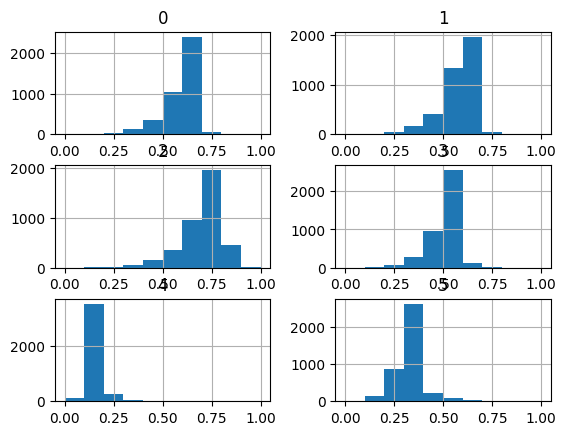

In [20]:
df_scaled_y_train = pd.DataFrame(scaled_y_train)
df_scaled_y_train.hist()

In [22]:
#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

In [23]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

In [24]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/torch/csrc/utils/tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [25]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [26]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [21]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_57583/3458591713.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_57583/3458591713.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_57583/3458591713.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/

         Task_1_Output_1  Task_2_Output_1  Task_3_Output_1
MAE                 3.10             0.47             0.27
MAE2                2.83             0.44             0.23
MSE                16.15             0.37             0.08
RMSE               16.15             0.37             0.08
MAPE                0.34             0.01             0.00
MAXE                7.28             1.03             0.45
EVS                 0.13             0.04             0.54
R2                 -0.77            -0.35             0.48
AVG_STD            12.61             1.37             0.89
MIN_STD            11.61             1.34             0.83
MAX_STD            14.03             1.41             0.96
         Task_1_Output_1  Task_2_Output_1  Task_3_Output_1
MAE                 2.44             0.59             0.29
MAE2                2.22             0.51             0.25
MSE                10.73             0.53             0.12
RMSE               10.73             0.53             0.

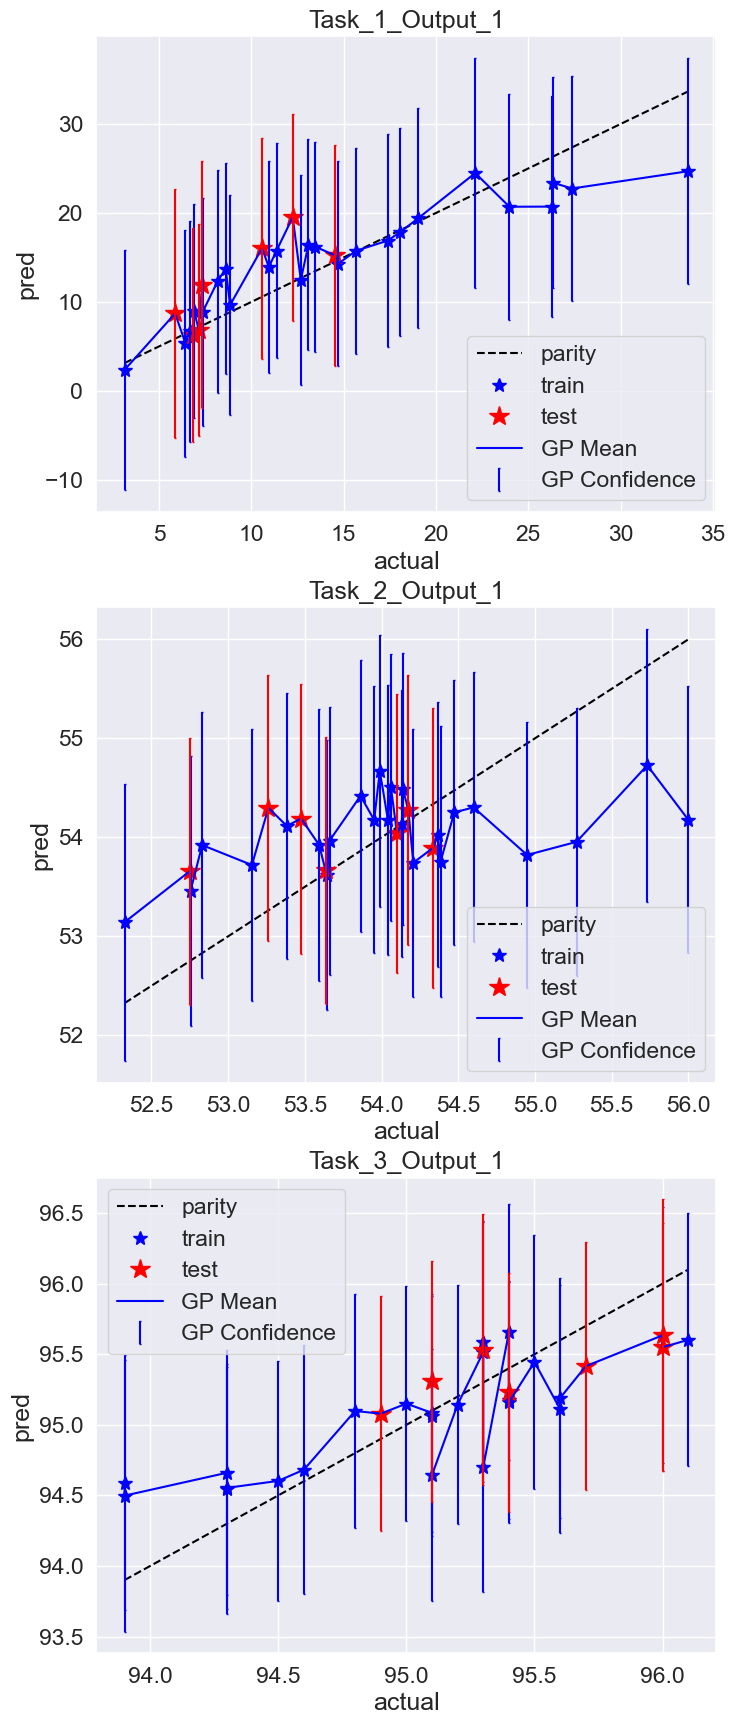

In [43]:
from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_wide = []

plot_axis_lb = df_y.min(axis = 0) - 0.4 * df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4 * df_y.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = 6
num_tasks = 23

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j in range(num_outputs):
    a = j + num_outputs*task_ind
    tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+str(j+1)
    cols_target_wide.append(tmp_col_y)
    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')